In [2]:
#pip install dice_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.3 MB/s eta 0:00:00


In [10]:
import dice_ml
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons
import tensorflow as tf
from tensorflow import keras
from numpy.linalg import norm
from shapely.geometry import Polygon
from sklearn.datasets import load_wine

import matplotlib.pyplot as plt

In [4]:
def generate_halfmoons(n_samples,noise,verbose=True):
    X , y = make_moons(n_samples,noise=noise)

    if verbose  : plt.scatter(X[:,0],X[:,1],c=y)

    return X , y



def plot_decision_boundary(X, y, model,sample,contrf,title="Counterfactual"):

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = np.round(model.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)


    # have to sort points in order to get a polygon
    points  = np.array(contrf)[:,:2]
    new_points = points[points[:, 0].argsort()]
    a , b = zip(*new_points)

    if sample is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.scatter(sample[0], sample[1], c='pink', marker='o', s=50, label='Sample')
        for con in contrf[:-1]:
            plt.scatter(con[0], con[1], c='yellow', marker='X', s=50)
        plt.scatter(contrf[-1][0], contrf[-1][1], c='yellow', marker='X', s=50,label=title)
        plt.plot(a + (a[0],), b + (b[0],), c='blue')
        plt.fill(a, b, alpha=0.5, color='yellow',label="Diveristy with area")
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Grawing Sphere "+title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.legend()
    plt.show()

## Data import

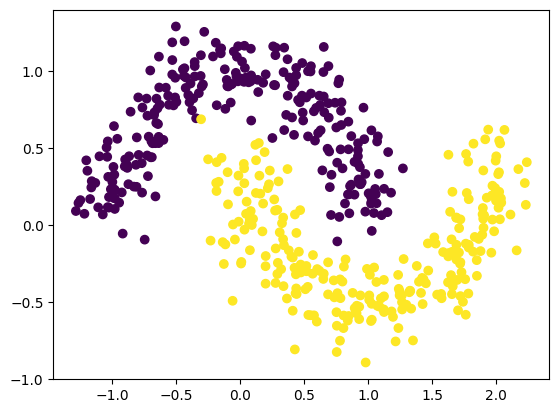

In [5]:
n_samples = 500
noise = 0.15
X , y = generate_halfmoons(n_samples,noise,verbose=True)

In [6]:
df = pd.DataFrame(X,columns=["x1","x2"])
df["class"] = y

# load the data as DiCE format
data = dice_ml.Data(dataframe = df,continuous_features = ["x1","x2"],outcome_name="class")

## Classifiers

- Creating a neural network with some hidden layers to learn a non lineaire boundary

In [7]:

NN_3 = keras.Sequential([
    keras.layers.Input(shape=(2,)),
    keras.layers.Dense(20, activation='tanh'),
    keras.layers.Dense(17, activation='relu'),
    keras.layers.Dense(6, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

NN_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

NN_3.fit(X, y, epochs=200, batch_size=100)

Epoch 1/200
5/5 [==============================] - 3s 13ms/step - loss: 0.7360 - accuracy: 0.3880
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.5460
Epoch 3/200
5/5 [==============================] - 0s 5ms/step - loss: 0.6656 - accuracy: 0.6680
Epoch 4/200
5/5 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.7700
Epoch 5/200
5/5 [==============================] - 0s 8ms/step - loss: 0.6082 - accuracy: 0.8560
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5822 - accuracy: 0.8800
Epoch 7/200
5/5 [==============================] - 0s 5ms/step - loss: 0.5586 - accuracy: 0.8820
Epoch 8/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5360 - accuracy: 0.8780
Epoch 9/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5155 - accuracy: 0.8740
Epoch 10/200
5/5 [==============================] - 0s 5ms/step - loss: 0.4967 - accuracy: 0.8720
Epoch 11/200
5/5 [==========

# Generation of counterfactual

In [60]:
def generate_counterfactual_samples(trained_classifier,X,y,feature_names,sample_ind,total_CFs,proximity_weight,diversity_weight,verbose=True):
    """
    **trained_classifier** : a classifier already trained on some data
    **sample_ind** : the index of the sample to generate counterfactual examples
    **total_CFs** : the number of counterfactual examples to generate
    **proximity_weight** : proximity weight to DiCE algorithme
    **diversity_weight** : diversity weight to DiCE algorithme
    """


    # load the classfier as format DiCE
    model = dice_ml.Model(model=trained_classifier, backend="TF1")

    # prepare data
    df = pd.DataFrame(X,columns=feature_names)
    df["class"] = y

    # load the data as DiCE format
    data = dice_ml.Data(dataframe = df,continuous_features =feature_names,outcome_name="class")

    # an explainer is initialized
    explainer = dice_ml.Dice(data, model)

    # the sample we want to generate diverse counterfactual exemples
    query_inst = pd.DataFrame(df.iloc[sample_ind:sample_ind+1,:X[0].shape[0]],columns=feature_names)


    # generation

    counterfactuals = explainer.generate_counterfactuals(
        query_inst,
        total_CFs,
        desired_class="opposite",
        proximity_weight=proximity_weight,
        diversity_weight=diversity_weight,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.3)

    # just to visualize counterfactual examples
    #print(counterfactuals.visualize_as_dataframe())

    # counterfactual predictions
    counterfactual_predictions = counterfactuals.cf_examples_list[0].final_cfs_df.iloc[:,2]


    # get the enemies
    enemies = counterfactuals.cf_examples_list[0].final_cfs_df

    # plot
    if verbose: plot_decision_boundary(X, y,trained_classifier,X[sample_ind],np.array(enemies))


    return enemies , counterfactual_predictions

# Variations

## vary the sample request

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

  32/7185 [..............................] - ETA: 11s  

7185/7185 [==============================] - 12s 2ms/step


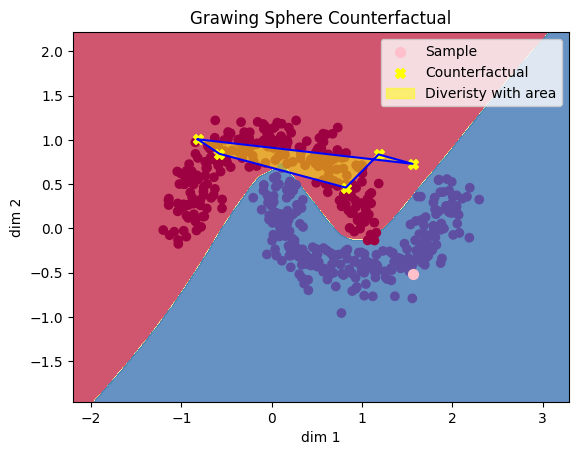

In [ ]:
trained_classifier = NN_3
feature_names = ['x1','x2']
sample_ind = 0
total_CFs = 5
proximity_weight = 0.8
diversity_weight = 1.0

enemies , preds = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight)

100%|██████████| 1/1 [00:59<00:00, 59.67s/it]

  37/7276 [..............................] - ETA: 10s  

7276/7276 [==============================] - 11s 2ms/step


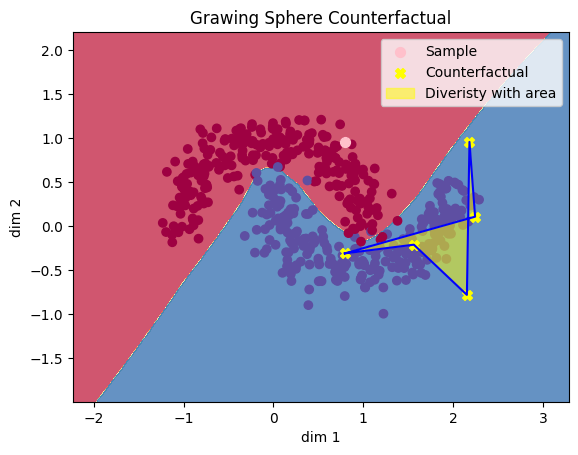

In [10]:
trained_classifier = NN_3
sample_ind = 16
total_CFs = 5
proximity_weight = 0.7
diversity_weight = 1.0

enemies , preds = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight)

## Vary parameters

We define three situations
- 1 --> we focus on the diversity
- 2 --> we focus on the proximity
- 3 --> a compromise between the diversity and the proximity.

and then we'll see the results of the algorithme on this situations.

Focus diveristy


100%|██████████| 1/1 [01:05<00:00, 65.51s/it]

  68/7185 [..............................] - ETA: 10s

7185/7185 [==============================] - 12s 2ms/step


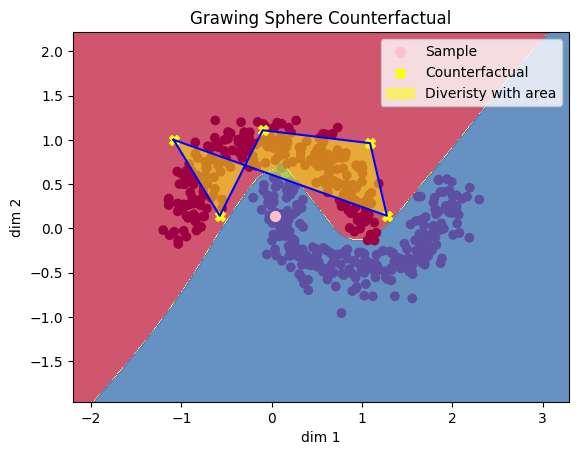

Focus proximity


100%|██████████| 1/1 [03:05<00:00, 185.54s/it]

  49/7185 [..............................] - ETA: 15s

7185/7185 [==============================] - 13s 2ms/step


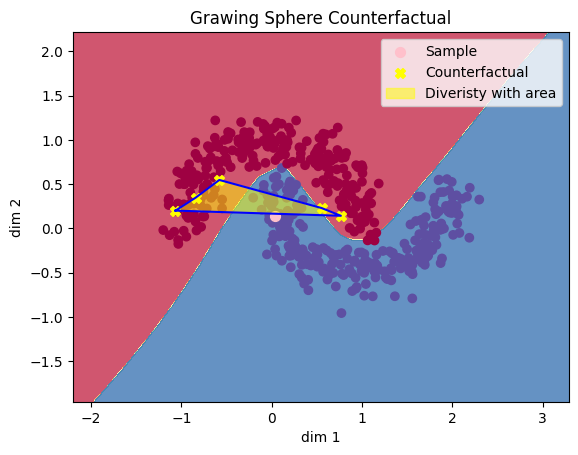

Compromise diversity/proximity


100%|██████████| 1/1 [01:03<00:00, 63.12s/it]

  68/7185 [..............................] - ETA: 10s

7185/7185 [==============================] - 12s 2ms/step


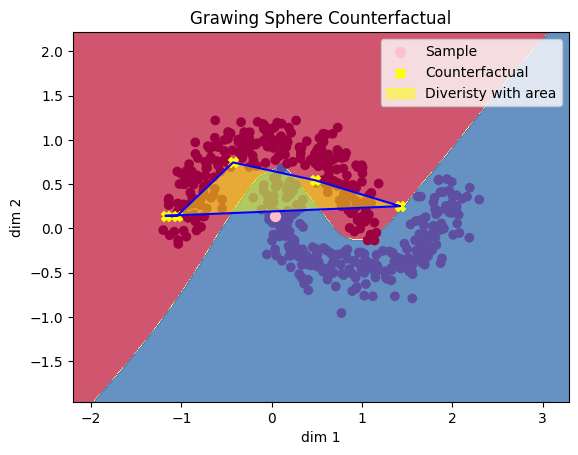

In [ ]:
situations = [[1.0 , 9.0] , [9.0 , 1.0] , [1.5 , 1.5]]
messages = ["Focus diveristy" , "Focus proximity" , "Compromise diversity/proximity"]

trained_classifier = NN_3
sample_ind = 96
total_CFs = 5


for i,situ in enumerate(situations):
  print(messages[i])
  enemies , _ = generate_counterfactual_samples(
          trained_classifier,
          X,y,feature_names,
          sample_ind,
          total_CFs,
          situ[0],
          situ[1])


- We note that by using parameters that allow a total focus on diversity, we obtain diverse counterfactual examples covering a rather large area for the polygon.
- So much so that by focusing on proximity, we obtain examples close to the original example without having a huge diversity of counterfactuals.
- The most interesting case is the one that combines a compromise between diversity and proximity: we obtain a polygon with a practically large surface area (high diversity) while remaining in an area close to the original example.

## Define the relevance metric

- We defend a metric of increasing relevance (as long as it is great as long as the generation of counterfactual examples is more relevant).
- We defend a weighted average of 4 entities ( validity , diveristy , parsimony , proximity ) For the first 3 we want their values to be large while for the last one we want it to be smaller at most ( closer to the original example ) that's why in the metric we take the weight associated with proximity multiplied by 1/proximity .
- Before applying the weighted average, the 4 criteria are normalized on the basis of a range of values provided as parameters.
- A combination of parameters giving a score of 2 is more relevant than one giving a score of 1.5.


In [9]:

def proximity(vector1,vector2):

    return norm(vector1 - vector2)


def relevance(sample,enemies,counterfactual_predictions,prediction_target,plage_norm,weights,verbose=False):
    """
    **sample** : sample for which we want to generate counterfactuals
    **enemies** : counterfactuals
    **counterfactual_predictions** : the model's predictions on counterfactuals
    **predicition_target** : the model's prediction on the sample
    **plage_norm** : the range in which normalization is performed
    **weights** : weights of the four criteria

    """

    plage_norm_min,plage_norm_max = plage_norm

    # validity between 0.0 and 1.0
    # the others criteria are higher that 1 so we'll translate this mean to [2,4]
    validity = np.where(prediction_target != counterfactual_predictions,1,0).mean()
    validity_norm = (validity - 0) / (1 - 0) * (plage_norm_max - plage_norm_min) + plage_norm_min

    # proximity
    proxi = proximity(sample,enemies)
    proxi_2 = int(proxi + 1)
    proxi_1 = int(proxi - 1)
    proxi_norm = (proxi -proxi_1 ) / (proxi_2 - proxi_1) * (plage_norm_max - plage_norm_min) + plage_norm_min
    # because we want to minimize the proximity between the sample and his counterfactuals , we'll use (1/proxi_norm)
    # we will encourage in our metric that the proximity is as low as possible
    proxi_norm = 1 / proxi_norm


    # diveristy : surface area of the geometric shape formed by the points
    new_ene = enemies.iloc[enemies.iloc[:, 0].argsort()]
    polygon = Polygon(new_ene)
    diveristy = polygon.area
    diveristy_2 = int(diveristy + 1)
    diveristy_1 = int(diveristy - 1)
    diveristy_norm = (diveristy - diveristy_1) / (diveristy_2 - diveristy_1) * (plage_norm_max - plage_norm_min) + plage_norm_min

    # sparsness
    sparsness = len(np.where(sample == enemies)[0]) / (enemies.shape[0]*enemies.shape[1])
    sparsness_norm = (sparsness - 0) / (1 - 0) * (plage_norm_max - plage_norm_min) + plage_norm_min

    # display
    if verbose:
      print(f"Validity : {validity} , Proximity : {proxi} , Diversity : {diveristy} , Sparsness : {sparsness}")


    # relevance : weighted mean
    return (weights * np.array([validity_norm,proxi_norm,diveristy_norm, sparsness_norm])).mean() , [validity,proxi,diveristy,sparsness]

100%|██████████| 1/1 [00:05<00:00,  5.60s/it]

  49/7276 [..............................] - ETA: 15s

7276/7276 [==============================] - 11s 2ms/step


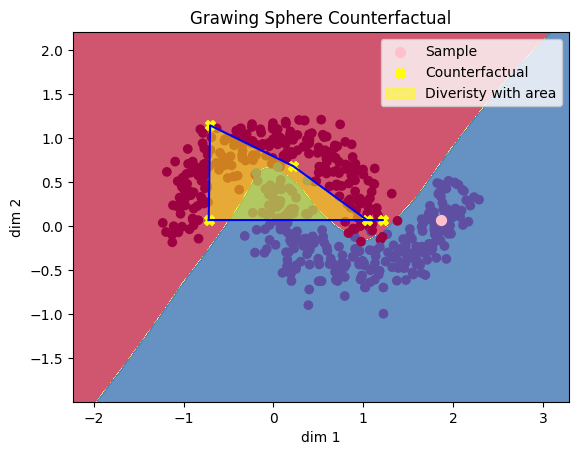

16/16 [==============================] - 0s 2ms/step
Validity : 1.0 , Proximity : 4.31033174807136 , Diversity : 1.0406089403375751 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 7.55388796577279


In [21]:
trained_classifier = NN_3
sample_ind = 14
total_CFs = 5
proximity_weight = 0.7
diversity_weight = 1.0

enemies , counterfactual_predictions = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight,
        verbose=True)


sample = X[sample_ind]
counters = enemies.iloc[:,:2]
plage_norm = [2,4]
prediction_target = int(np.round(NN_3.predict(X))[sample_ind][0])
# validity , proximity , diveristy , sparsness
weights= np.array([2,6,5,2])
rele , _ = relevance(sample,counters,counterfactual_predictions,prediction_target,plage_norm,weights,True)
print(f"Relevance of the counterfactuals generation on this configuration is {rele}")

In [33]:
situations = [[1.0 , 9.0] , [9.0 , 1.0] , [1.5 , 1.5]]
messages = ["Focus diveristy" , "Focus proximity" , "Compromise diversity/proximity"]

trained_classifier = NN_3
# sample_ind = 14
samples = [14,96,24,10,6,23]
total_CFs = 5

relevances = []
validities = []
proximities = []
diversities = []
sparsnesses = []
tmp_v = []
tmp_r = []
tmp_p = []
tmp_s = []
tmp_d = []

for i,situ in enumerate(situations):
    for sample_ind in samples:
        print(messages[i])
        enemies , _ = generate_counterfactual_samples(
                trained_classifier,
                X,y,feature_names,
                sample_ind,
                total_CFs,
                situ[0],
                situ[1],
                verbose=False)

        sample = X[sample_ind]
        counters = enemies.iloc[:,:2]
        plage_norm = [2,4]
        prediction_target = int(np.round(NN_3.predict(X))[sample_ind][0])
        # validity , proximity , diveristy , sparsness
        weights= np.array([2,6,5,2])
        rele , criteria_values = relevance(sample,counters,counterfactual_predictions,prediction_target,plage_norm,weights,True)
        print(f"Relevance of the counterfactuals generation on this configuration is {rele}")
        tmp_r.append(rele)
        tmp_v.append(criteria_values[0])
        tmp_p.append(criteria_values[1])
        tmp_d.append(criteria_values[2])
        tmp_s.append(criteria_values[3])
    relevances.append(np.mean(tmp_r))
    validities.append(np.mean(tmp_v))
    proximities.append(np.mean(tmp_p))
    diversities.append(np.mean(tmp_d))
    sparsnesses.append(np.mean(tmp_s))


Focus diveristy


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 4.0030687754570975 , Diversity : 0.02764507914198707 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 6.368601757932082
Focus diveristy


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 2.7303437273751587 , Diversity : 0.6569429429160498 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 7.74446507433299
Focus diveristy


100%|██████████| 1/1 [01:00<00:00, 60.79s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 3.5389892937222664 , Diversity : 1.4040564898813637 , Sparsness : 0.0
Relevance of the counterfactuals generation on this configuration is 6.678920439380233
Focus diveristy


100%|██████████| 1/1 [01:00<00:00, 60.57s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 2.7089333169634937 , Diversity : 0.03401588072466505 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 6.389468649924446
Focus diveristy


100%|██████████| 1/1 [01:00<00:00, 60.22s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 2.3430898100299835 , Diversity : 0.011929997174502216 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 6.27851171247926
Focus diveristy


100%|██████████| 1/1 [01:59<00:00, 119.13s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 2.4889542085937184 , Diversity : 0.10949090968531312 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 5.503655530739355
Focus proximity


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 2.0521770088174014 , Diversity : 0.04335117513388598 , Sparsness : 0.5
Relevance of the counterfactuals generation on this configuration is 6.599830430814862
Focus proximity


100%|██████████| 1/1 [01:00<00:00, 60.48s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 2.1318553173829424 , Diversity : 0.32109090535465395 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 7.181676591497181
Focus proximity


100%|██████████| 1/1 [01:00<00:00, 60.22s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 2.8652514804283427 , Diversity : 0.2575184069591544 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 5.731869085242303
Focus proximity


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 3.590281123374689 , Diversity : 0.19006196047322907 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 6.692949482848051
Focus proximity


100%|██████████| 1/1 [01:56<00:00, 116.32s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 3.1112413987464502 , Diversity : 0.9551725877541568 , Sparsness : 0.1
Relevance of the counterfactuals generation on this configuration is 8.470054136113973
Focus proximity


100%|██████████| 1/1 [01:00<00:00, 60.60s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 2.7112738251697093 , Diversity : 0.009932481901450033 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 5.22900510047295
Compromise diversity/proximity


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 4.159317696981269 , Diversity : 0.4671965309780337 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 7.442777386926614
Compromise diversity/proximity


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 2.3589457302393213 , Diversity : 1.0359215043510719 , Sparsness : 0.3
Relevance of the counterfactuals generation on this configuration is 7.541470572066117
Compromise diversity/proximity


100%|██████████| 1/1 [00:58<00:00, 58.80s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 0.0 , Proximity : 3.238436001738428 , Diversity : 0.46991594970821704 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 6.5379764245666685
Compromise diversity/proximity


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 3.753392879097848 , Diversity : 0.4993408005501211 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 7.34799042141742
Compromise diversity/proximity


100%|██████████| 1/1 [00:59<00:00, 59.92s/it]

16/16 [==============================] - 0s 2ms/step


Validity : 1.0 , Proximity : 2.984063971384317 , Diversity : 0.170844822039794 , Sparsness : 0.4
Relevance of the counterfactuals generation on this configuration is 6.703612033707712
Compromise diversity/proximity


100%|██████████| 1/1 [00:59<00:00, 59.32s/it]

16/16 [==============================] - 0s 2ms/step
Validity : 0.0 , Proximity : 2.9652061038493294 , Diversity : 0.7014096893105747 , Sparsness : 0.2
Relevance of the counterfactuals generation on this configuration is 6.831814773808939


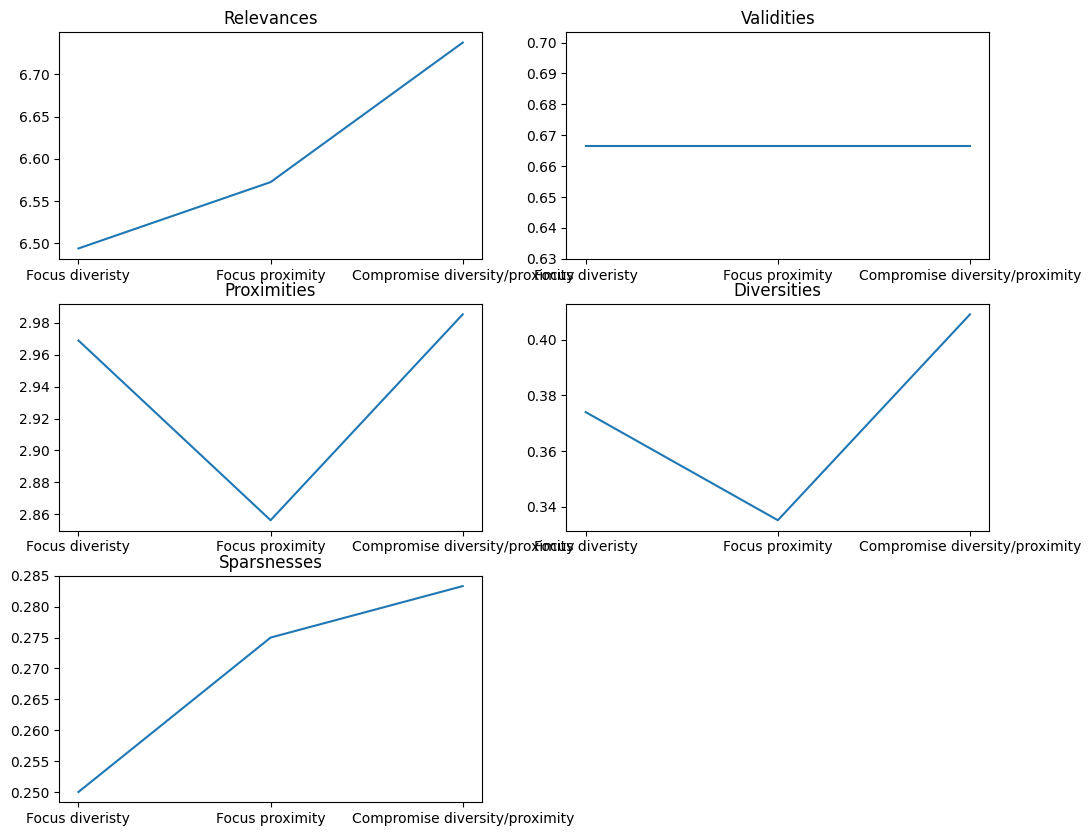

In [34]:
plt.figure(figsize=(12,10))
plt.subplot(321)
plt.title("Relevances")
plt.plot(messages , relevances)

plt.subplot(322)
plt.title("Validities")
plt.plot(messages , validities)

plt.subplot(323)
plt.title("Proximities")
plt.plot(messages , proximities)

plt.subplot(324)
plt.title("Diversities")
plt.plot(messages , diversities)

plt.subplot(325)
plt.title("Sparsnesses")
plt.plot(messages , sparsnesses)

We note that :
- The diversity/proximity compromise strategy is the most relevant.
- On average, there may be situations where the proximity/diversity combination produces more diversity than the pure strategy, because depending on the example chosen, it may be in an area where its counterfactuals will be more diverse than if they were far from the original example.
- Sparsness match well with the diverist/proximity strategy, because by being diverse and close, we're more likely to find the same values as the original example.
- Validity is more or less stable whatever the strategy.

## Wine Data

In [50]:
# Load the Wine dataset
wine_data = load_wine()

# Access the features and target variables
X = wine_data.data  # Features
y = wine_data.target  # Target variable

feature_names = list(np.array(wine_data.feature_names))
target_names = wine_data.target_names
dataset_description = wine_data.DESCR

In [51]:
NN_3_bis = keras.Sequential([
    keras.layers.Input(shape=(13,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

NN_3_bis.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

NN_3_bis.fit(X, y, epochs=40, batch_size=32)

Epoch 1/40
6/6 [==============================] - 1s 4ms/step - loss: 157.6745 - accuracy: 0.2697
Epoch 2/40
6/6 [==============================] - 0s 3ms/step - loss: 118.5122 - accuracy: 0.2697
Epoch 3/40
6/6 [==============================] - 0s 4ms/step - loss: 83.1480 - accuracy: 0.2697
Epoch 4/40
6/6 [==============================] - 0s 3ms/step - loss: 51.9451 - accuracy: 0.3034
Epoch 5/40
6/6 [==============================] - 0s 3ms/step - loss: 42.9800 - accuracy: 0.3315
Epoch 6/40
6/6 [==============================] - 0s 5ms/step - loss: 31.9054 - accuracy: 0.3315
Epoch 7/40
6/6 [==============================] - 0s 4ms/step - loss: 18.1577 - accuracy: 0.3427
Epoch 8/40
6/6 [==============================] - 0s 3ms/step - loss: 8.2744 - accuracy: 0.2753
Epoch 9/40
6/6 [==============================] - 0s 3ms/step - loss: 2.6410 - accuracy: 0.4326
Epoch 10/40
6/6 [==============================] - 0s 3ms/step - loss: 3.3895 - accuracy: 0.4888
Epoch 11/40
6/6 [=============

In [61]:
trained_classifier = NN_3_bis
sample_ind = 14
total_CFs = 5
proximity_weight = 0.8
diversity_weight = 1.0

enemies , preds = generate_counterfactual_samples(
        trained_classifier,
        X,y,feature_names,
        sample_ind,
        total_CFs,
        proximity_weight,
        diversity_weight)

  0%|          | 0/1 [00:00<?, ?it/s]


UserConfigValidationException: ignored